In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
import datetime
from bayes_opt import BayesianOptimization

In [4]:
df = pd.read_csv('./data/FW_base_v1.csv', index_col = 0)

obj_columns = df.select_dtypes(include=['object']).columns
# Apply one-hot encoding to object columns
df = pd.get_dummies(df, columns = obj_columns, drop_first = True)

y = df.TARGET
X = df.drop('TARGET', axis = 1)
X = X.replace([np.inf, -np.inf], np.nan)
X.fillna(0.0, inplace = True)

In [5]:
import xgboost as xgb

# XGBoost 直接存取 dataframe
data_dmatrix = xgb.DMatrix(data=X,label=y)

X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size = 0.1, random_state = 37)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size = 0.5, random_state = 37)

In [8]:
params = {"objective":"binary:logistic",
          'learning_rate': 0.01,
          'n_estimators': 3000,
          'early_stopping_rounds': 300, 
          'scale_pos_weight' : 14,
          'colsample_bytree': 0.7673,
          'gamma': 0.4247, # min_split_loss
          'max_depth': 9,
          'max_leaves': 42,
          'min_child_weight': 67,
          'reg_alpha': 0.3742,
          'reg_lambda': 0.6608,
          'subsample': 0.8823,
          'random_state' : 37
          }

evals_result = {}

start_time = time.time()

xgbm = xgb.XGBClassifier(**params)
xgbm.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_metric='auc',
)

end_time = time.time()
execution_time = end_time - start_time

y_pred =xgbm.predict(X_test)
y_pred_prob = xgbm.predict_proba(X_test)

print("\n程式執行花費的时间：", round(execution_time, 2), "秒")
print("完成时间:", datetime.datetime.now())

c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.72119	validation_1-auc:0.68607
[1]	validation_0-auc:0.76012	validation_1-auc:0.72206
[2]	validation_0-auc:0.76764	validation_1-auc:0.73558
[3]	validation_0-auc:0.77126	validation_1-auc:0.73872
[4]	validation_0-auc:0.77293	validation_1-auc:0.74161
[5]	validation_0-auc:0.77642	validation_1-auc:0.74606
[6]	validation_0-auc:0.77799	validation_1-auc:0.74602
[7]	validation_0-auc:0.77808	validation_1-auc:0.74601
[8]	validation_0-auc:0.77830	validation_1-auc:0.74503
[9]	validation_0-auc:0.78015	validation_1-auc:0.74711
[10]	validation_0-auc:0.78041	validation_1-auc:0.74665
[11]	validation_0-auc:0.78157	validation_1-auc:0.74773
[12]	validation_0-auc:0.78227	validation_1-auc:0.74874
[13]	validation_0-auc:0.78353	validation_1-auc:0.74995
[14]	validation_0-auc:0.78385	validation_1-auc:0.74993
[15]	validation_0-auc:0.78376	validation_1-auc:0.75025
[16]	validation_0-auc:0.78381	validation_1-auc:0.75028
[17]	validation_0-auc:0.78376	validation_1-auc:0.75057
[18]	validation_0-au

In [9]:
roc_auc_score(y_test, y_pred_prob[:,1])

0.7434828756407955

In [ ]:
# weight: the number of times a feature is used to split the data across all trees.weight
xgb.plot_importance(xgbm, max_num_features=20, importance_type='weight', xlabel= 'weight')

In [6]:
y_pred_prob = xgbm.predict_proba(X_val)
y_pred_prob = y_pred_prob[:,1]
fpr, tpr, thresh = metrics.roc_curve(y_val, y_pred_prob)
auc = metrics.roc_auc_score(y_val, y_pred_prob)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr,tpr,label="val = %0.2f" % roc_auc)

y_pred_prob = xgbm.predict_proba(X_test)
y_pred_prob = y_pred_prob[:,1]
fpr, tpr, thresh = metrics.roc_curve(y_test, y_pred_prob)
roc_auc = metrics.auc(fpr, tpr)
plt.title('AUC')
plt.plot(fpr, tpr, 'b', label='test = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

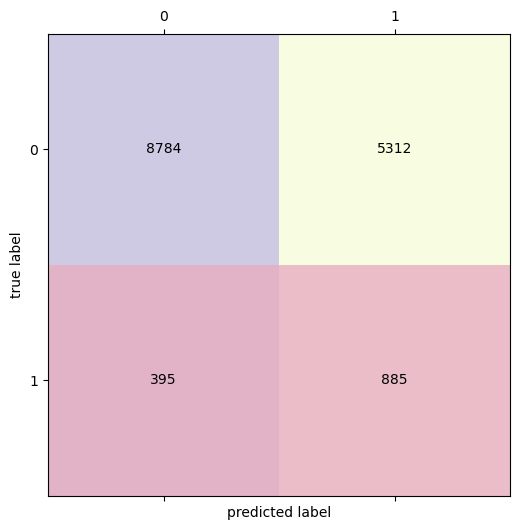

In [7]:
from sklearn.metrics import confusion_matrix

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig, ax = plt.subplots(figsize = (6, 6))
ax.matshow(confmat, cmap = 'Spectral', alpha = 0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i,
                s=confmat[i,j],
                va='center',ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc
# 初始化验证集和测试集的真实标签
y_true_valid = y_val
y_true_test = y_test
eval_result = xgbm.evals_result()

# 获取迭代次数和AUC值的记录
iterations = (0, len(eval_result['validation_0']['auc']))
valid_auc_values = eval_result['validation_0']['auc']

# 初始化存储AUC值的列表
valid_auc = []
test_auc = []

# 使用模型的predict_proba方法来获取概率值
for iteration in list(range(iterations[0], iterations[1] + 1)):
    y_pred_prob_valid = xgbm.predict_proba(X_val, iteration_range=(0, iteration))[:, 1]
    y_pred_prob_test = xgbm.predict_proba(X_test, iteration_range=(0, iteration))[:, 1]

    # 计算验证集和测试集的ROC曲线
    fpr_valid, tpr_valid, _ = roc_curve(y_true_valid[:], y_pred_prob_valid)
    fpr_test, tpr_test, _ = roc_curve(y_true_test[:], y_pred_prob_test)

    # 计算验证集和测试集的AUC值
    roc_auc_valid = auc(fpr_valid, tpr_valid)
    roc_auc_test = auc(fpr_test, tpr_test)

    # 将AUC值添加到列表中
    valid_auc.append(roc_auc_valid)
    test_auc.append(roc_auc_test)

# 绘制AUC曲线
plt.figure(figsize=(10, 6))
array_result = np.array(list(range(iterations[0], iterations[1])))
plt.plot(array_result, valid_auc[1:], label=f'Validation AUC = {valid_auc[-1]:.4f})', marker='o')
plt.plot(array_result, test_auc[1:], label=f'Test AUC = {test_auc[-1]:.4f})', marker='x')
plt.xlabel('Iterations')
plt.ylabel('AUC')
plt.title('AUC vs. Iterations')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.62      0.75     14096
           1       0.14      0.69      0.24      1280

    accuracy                           0.63     15376
   macro avg       0.55      0.66      0.50     15376
weighted avg       0.89      0.63      0.71     15376



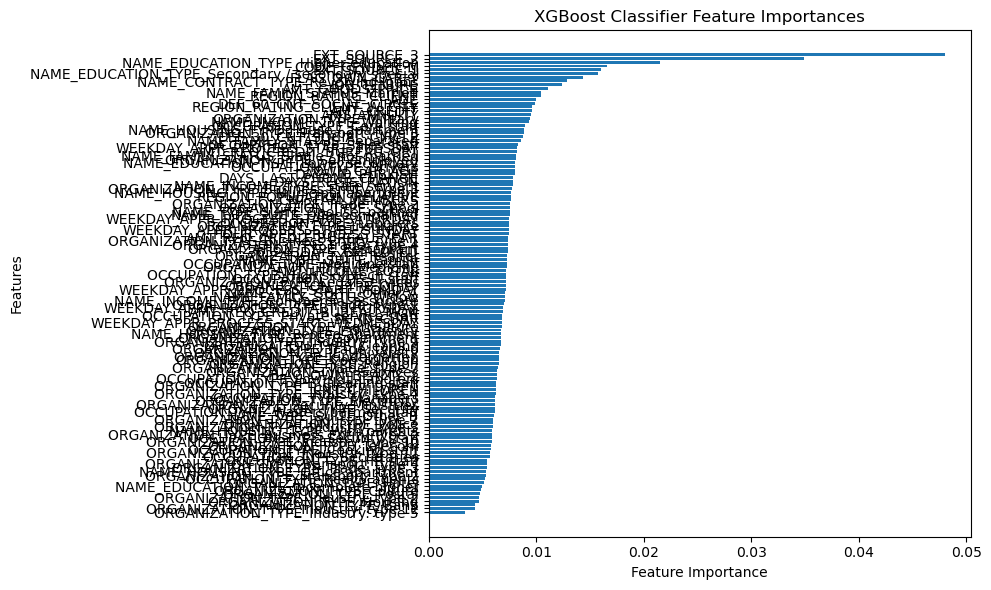

In [9]:
feature_importances = pipe_xgb.steps[1][1].feature_importances_

# Get feature names from the pipeline
feature_names = X_train.columns

# Sort feature importances in ascending order
sorted_indices = np.argsort(feature_importances)[::1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

important_indices = np.where(sorted_feature_importances != 0)[0]
important_feature_importances = sorted_feature_importances[important_indices]
important_feature_names = sorted_feature_names[important_indices]
# Plotting
plt.figure(figsize=(10, 6))
plt.barh(range(len(important_feature_importances)), important_feature_importances, tick_label=important_feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('XGBoost Classifier Feature Importances')
plt.tight_layout()
plt.show()

In [10]:
import json
# create json save function
def fullname(o):
  return o.__module__ + "." + o.__class__.__name__

def export_pipeline(pipeline):
  """JSON export of a scikit-learn pipeline.
  
  Especially useful when paired with GridSearchCV, TPOT, etc.
    
  Example:
  best_model = GridSearchCV(
      some_pipeline,
      param_grid=some_tuning_parameters
  )
  best_model.fit(X=train_x, y=train_y)
  export_pipeline(best_model.best_estimator_)
  :param scikit_pipeline: a scikit-learn Pipeline object
  """
  steps_obj = {'steps':[]}
  for name, md in pipeline.steps:
      steps_obj['steps'].append({
          'name': name,
          'class_name': fullname(md),
          'params': md.get_params()
      })

  return steps_obj
# save the iris-classification model in a json file
def save_json(model, filepath):
    json_txt = json.dumps(export_pipeline(model), indent=4)
    with open(filepath, "w") as file: 
        file.write(json_txt)
file_name = 'xgb_model.json'
save_json(pipe_xgb, file_name)

In [11]:
# create json load function 
def load_json(filepath): 
    with open(filepath, "r") as file:
        saved_model = json.load(file)
    
    return saved_model

# load model configurations
saved_model = load_json('json_model.json')
saved_model

# evaluate model 
data = {
    "AMT_INCOME_TOTAL": [600],
    "CODE_GENDER_M": [0],
    "CODE_GENDER_XNA" : [0],
    "FLAG_OWN_CAR_Y": [0],
    "FLAG_OWN_REALTY_Y": [0]
}
data = pd.DataFrame(data)
y_pred = loaded_model.predict_proba(data)

# check results
print(y_pred[0][0])

FileNotFoundError: [Errno 2] No such file or directory: 'json_model.json'

調參

In [6]:
def xgb_evaluate(**params):
    
    params['max_leaves'] = int(params['max_leaves'])
    params['max_depth'] = int(params['max_depth'])
    # params['max_bins'] = int(params['max_bins'])
    # params['bagging_freq'] = int(params['bagging_freq'])
    
# bayes: 0.785(eta + iter) => (l1 + 12) => (num_leaves + max_depth + max_bins)
    clf = xgb.XGBClassifier(**params, 
                         learning_rate = 0.1,
                         n_estimators = 100,
                         nthread = 5, 
                         early_stopping_rounds = 500,
                         verbosity = 0,
                         silent = 1,
                        #  num_leaves = 31,
                        #  n_jobs = -1,
                         )

    folds = StratifiedKFold(n_splits= 5, shuffle=True, random_state=37)
        
    test_pred_proba = []
    # test_pred_proba = np.zeros(y_test.shape[0])
    
    feats = [f for f in df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    # 4 : 1 輪流
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X[feats], df['TARGET'])):
        train_x, train_y = X[feats].iloc[train_idx], df['TARGET'].iloc[train_idx]
        val_x, val_y = X[feats].iloc[valid_idx], df['TARGET'].iloc[valid_idx]

        clf.fit(X_train[feats], y_train, 
                eval_set = [(train_x, train_y), (val_x, val_y)], 
                eval_metric = 'auc', 
                )

        test_pred_proba = clf.predict_proba(X_test[feats], iteration_range = (0, clf.best_iteration))[:, 1]
        # test_pred_proba[valid_idx] = clf.predict_proba(X_test[feats], num_iteration = clf.best_iteration_)[:, 1]
        del train_x, train_y, val_x, val_y

    # return roc_auc_score(df['TARGET'], test_pred_proba)
    return roc_auc_score(y_test, test_pred_proba)

In [7]:
init_time = time.time()
params = {
          'max_leaves': (20, 100), 
        #   'bagging_freq': (.0, 1.0),
          'subsample' : (.1, 1.0),
          'max_depth': (4, 10), 
        #   'max_bins' : (20, 63),
          'reg_alpha': (.0, 1.0), 
          'reg_lambda': (.0, 1.0), 
          'colsample_bytree': (.1, 1.0), # feature_fraction
          'min_child_weight': (20, 100),
          'gamma': (.0, 1.0), # min_split_loss
           }
bo = BayesianOptimization(xgb_evaluate, params)
bo.maximize(init_points = 5, n_iter = 5)
print("Elapsed time={:5.2f} sec.".format(time.time() - init_time))

|   iter    |  target   | colsam... |   gamma   | max_depth | max_le... | min_ch... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------


c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.71103	validation_1-auc:0.70907
[1]	validation_0-auc:0.72106	validation_1-auc:0.72024
[2]	validation_0-auc:0.72574	validation_1-auc:0.72504
[3]	validation_0-auc:0.72927	validation_1-auc:0.73043
[4]	validation_0-auc:0.73198	validation_1-auc:0.73348
[5]	validation_0-auc:0.73450	validation_1-auc:0.73583
[6]	validation_0-auc:0.73636	validation_1-auc:0.73702
[7]	validation_0-auc:0.73813	validation_1-auc:0.73857
[8]	validation_0-auc:0.73920	validation_1-auc:0.73990
[9]	validation_0-auc:0.74014	validation_1-auc:0.74090
[10]	validation_0-auc:0.74138	validation_1-auc:0.74228
[11]	validation_0-auc:0.74255	validation_1-auc:0.74338
[12]	validation_0-auc:0.74354	validation_1-auc:0.74470
[13]	validation_0-auc:0.74429	validation_1-auc:0.74539
[14]	validation_0-auc:0.74496	validation_1-auc:0.74536
[15]	validation_0-auc:0.74563	validation_1-auc:0.74622
[16]	validation_0-auc:0.74638	validation_1-auc:0.74682
[17]	validation_0-auc:0.74709	validation_1-auc:0.74732
[18]	validation_0-au

c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.70941	validation_1-auc:0.71553
[1]	validation_0-auc:0.71950	validation_1-auc:0.72647
[2]	validation_0-auc:0.72446	validation_1-auc:0.73014
[3]	validation_0-auc:0.72826	validation_1-auc:0.73442
[4]	validation_0-auc:0.73107	validation_1-auc:0.73709
[5]	validation_0-auc:0.73379	validation_1-auc:0.73867
[6]	validation_0-auc:0.73555	validation_1-auc:0.74023
[7]	validation_0-auc:0.73731	validation_1-auc:0.74184
[8]	validation_0-auc:0.73853	validation_1-auc:0.74253
[9]	validation_0-auc:0.73955	validation_1-auc:0.74320
[10]	validation_0-auc:0.74086	validation_1-auc:0.74435
[11]	validation_0-auc:0.74198	validation_1-auc:0.74565
[12]	validation_0-auc:0.74305	validation_1-auc:0.74665
[13]	validation_0-auc:0.74388	validation_1-auc:0.74699
[14]	validation_0-auc:0.74448	validation_1-auc:0.74729
[15]	validation_0-auc:0.74515	validation_1-auc:0.74812
[16]	validation_0-auc:0.74572	validation_1-auc:0.74945
[17]	validation_0-auc:0.74644	validation_1-auc:0.74992
[18]	validation_0-au

c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.71095	validation_1-auc:0.70936
[1]	validation_0-auc:0.72169	validation_1-auc:0.71771
[2]	validation_0-auc:0.72636	validation_1-auc:0.72258
[3]	validation_0-auc:0.73040	validation_1-auc:0.72591
[4]	validation_0-auc:0.73317	validation_1-auc:0.72869
[5]	validation_0-auc:0.73541	validation_1-auc:0.73223
[6]	validation_0-auc:0.73706	validation_1-auc:0.73423
[7]	validation_0-auc:0.73875	validation_1-auc:0.73609
[8]	validation_0-auc:0.73991	validation_1-auc:0.73705
[9]	validation_0-auc:0.74085	validation_1-auc:0.73806
[10]	validation_0-auc:0.74208	validation_1-auc:0.73948
[11]	validation_0-auc:0.74328	validation_1-auc:0.74049
[12]	validation_0-auc:0.74431	validation_1-auc:0.74164
[13]	validation_0-auc:0.74511	validation_1-auc:0.74211
[14]	validation_0-auc:0.74554	validation_1-auc:0.74308
[15]	validation_0-auc:0.74623	validation_1-auc:0.74384
[16]	validation_0-auc:0.74702	validation_1-auc:0.74428
[17]	validation_0-auc:0.74761	validation_1-auc:0.74529
[18]	validation_0-au

c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.71050	validation_1-auc:0.71120
[1]	validation_0-auc:0.72120	validation_1-auc:0.71971
[2]	validation_0-auc:0.72582	validation_1-auc:0.72471
[3]	validation_0-auc:0.72960	validation_1-auc:0.72908
[4]	validation_0-auc:0.73235	validation_1-auc:0.73193
[5]	validation_0-auc:0.73489	validation_1-auc:0.73426
[6]	validation_0-auc:0.73651	validation_1-auc:0.73638
[7]	validation_0-auc:0.73814	validation_1-auc:0.73847
[8]	validation_0-auc:0.73926	validation_1-auc:0.73959
[9]	validation_0-auc:0.74008	validation_1-auc:0.74111
[10]	validation_0-auc:0.74145	validation_1-auc:0.74201
[11]	validation_0-auc:0.74265	validation_1-auc:0.74299
[12]	validation_0-auc:0.74389	validation_1-auc:0.74330
[13]	validation_0-auc:0.74447	validation_1-auc:0.74464
[14]	validation_0-auc:0.74483	validation_1-auc:0.74583
[15]	validation_0-auc:0.74550	validation_1-auc:0.74671
[16]	validation_0-auc:0.74625	validation_1-auc:0.74729
[17]	validation_0-auc:0.74688	validation_1-auc:0.74814
[18]	validation_0-au

c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.71131	validation_1-auc:0.70798
[1]	validation_0-auc:0.72105	validation_1-auc:0.72030
[2]	validation_0-auc:0.72563	validation_1-auc:0.72547
[3]	validation_0-auc:0.72997	validation_1-auc:0.72761
[4]	validation_0-auc:0.73281	validation_1-auc:0.73014
[5]	validation_0-auc:0.73526	validation_1-auc:0.73280
[6]	validation_0-auc:0.73699	validation_1-auc:0.73452
[7]	validation_0-auc:0.73876	validation_1-auc:0.73605
[8]	validation_0-auc:0.73978	validation_1-auc:0.73756
[9]	validation_0-auc:0.74083	validation_1-auc:0.73810
[10]	validation_0-auc:0.74205	validation_1-auc:0.73963
[11]	validation_0-auc:0.74314	validation_1-auc:0.74104
[12]	validation_0-auc:0.74409	validation_1-auc:0.74254
[13]	validation_0-auc:0.74479	validation_1-auc:0.74338
[14]	validation_0-auc:0.74540	validation_1-auc:0.74362
[15]	validation_0-auc:0.74623	validation_1-auc:0.74383
[16]	validation_0-auc:0.74698	validation_1-auc:0.74445
[17]	validation_0-auc:0.74768	validation_1-auc:0.74498
[18]	validation_0-au

c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.71315	validation_1-auc:0.71039
[1]	validation_0-auc:0.72237	validation_1-auc:0.72044
[2]	validation_0-auc:0.72827	validation_1-auc:0.72656
[3]	validation_0-auc:0.73107	validation_1-auc:0.72952
[4]	validation_0-auc:0.73340	validation_1-auc:0.73211
[5]	validation_0-auc:0.73529	validation_1-auc:0.73459
[6]	validation_0-auc:0.73549	validation_1-auc:0.73429
[7]	validation_0-auc:0.73816	validation_1-auc:0.73677
[8]	validation_0-auc:0.73861	validation_1-auc:0.73739
[9]	validation_0-auc:0.73932	validation_1-auc:0.73844
[10]	validation_0-auc:0.74033	validation_1-auc:0.73948
[11]	validation_0-auc:0.74156	validation_1-auc:0.74063
[12]	validation_0-auc:0.74193	validation_1-auc:0.74107
[13]	validation_0-auc:0.74237	validation_1-auc:0.74113
[14]	validation_0-auc:0.74387	validation_1-auc:0.74262
[15]	validation_0-auc:0.74425	validation_1-auc:0.74333
[16]	validation_0-auc:0.74456	validation_1-auc:0.74373
[17]	validation_0-auc:0.74498	validation_1-auc:0.74425
[18]	validation_0-au

c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.71101	validation_1-auc:0.71894
[1]	validation_0-auc:0.72113	validation_1-auc:0.72537
[2]	validation_0-auc:0.72738	validation_1-auc:0.73012
[3]	validation_0-auc:0.73018	validation_1-auc:0.73306
[4]	validation_0-auc:0.73246	validation_1-auc:0.73586
[5]	validation_0-auc:0.73443	validation_1-auc:0.73801
[6]	validation_0-auc:0.73446	validation_1-auc:0.73839
[7]	validation_0-auc:0.73719	validation_1-auc:0.74066
[8]	validation_0-auc:0.73763	validation_1-auc:0.74129
[9]	validation_0-auc:0.73841	validation_1-auc:0.74204
[10]	validation_0-auc:0.73948	validation_1-auc:0.74290
[11]	validation_0-auc:0.74076	validation_1-auc:0.74385
[12]	validation_0-auc:0.74120	validation_1-auc:0.74400
[13]	validation_0-auc:0.74153	validation_1-auc:0.74444
[14]	validation_0-auc:0.74310	validation_1-auc:0.74568
[15]	validation_0-auc:0.74356	validation_1-auc:0.74605
[16]	validation_0-auc:0.74383	validation_1-auc:0.74664
[17]	validation_0-auc:0.74431	validation_1-auc:0.74691
[18]	validation_0-au

c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.71268	validation_1-auc:0.71228
[1]	validation_0-auc:0.72178	validation_1-auc:0.72279
[2]	validation_0-auc:0.72791	validation_1-auc:0.72799
[3]	validation_0-auc:0.73069	validation_1-auc:0.73102
[4]	validation_0-auc:0.73321	validation_1-auc:0.73286
[5]	validation_0-auc:0.73539	validation_1-auc:0.73417
[6]	validation_0-auc:0.73545	validation_1-auc:0.73447
[7]	validation_0-auc:0.73812	validation_1-auc:0.73698
[8]	validation_0-auc:0.73864	validation_1-auc:0.73730
[9]	validation_0-auc:0.73942	validation_1-auc:0.73805
[10]	validation_0-auc:0.74048	validation_1-auc:0.73888
[11]	validation_0-auc:0.74159	validation_1-auc:0.74053
[12]	validation_0-auc:0.74196	validation_1-auc:0.74098
[13]	validation_0-auc:0.74232	validation_1-auc:0.74132
[14]	validation_0-auc:0.74378	validation_1-auc:0.74299
[15]	validation_0-auc:0.74425	validation_1-auc:0.74335
[16]	validation_0-auc:0.74462	validation_1-auc:0.74351
[17]	validation_0-auc:0.74508	validation_1-auc:0.74389
[18]	validation_0-au

c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.71295	validation_1-auc:0.71119
[1]	validation_0-auc:0.72224	validation_1-auc:0.72096
[2]	validation_0-auc:0.72775	validation_1-auc:0.72861
[3]	validation_0-auc:0.73071	validation_1-auc:0.73093
[4]	validation_0-auc:0.73324	validation_1-auc:0.73272
[5]	validation_0-auc:0.73522	validation_1-auc:0.73481
[6]	validation_0-auc:0.73524	validation_1-auc:0.73526
[7]	validation_0-auc:0.73780	validation_1-auc:0.73821
[8]	validation_0-auc:0.73838	validation_1-auc:0.73829
[9]	validation_0-auc:0.73911	validation_1-auc:0.73927
[10]	validation_0-auc:0.74003	validation_1-auc:0.74066
[11]	validation_0-auc:0.74123	validation_1-auc:0.74192
[12]	validation_0-auc:0.74161	validation_1-auc:0.74234
[13]	validation_0-auc:0.74185	validation_1-auc:0.74317
[14]	validation_0-auc:0.74326	validation_1-auc:0.74503
[15]	validation_0-auc:0.74368	validation_1-auc:0.74559
[16]	validation_0-auc:0.74411	validation_1-auc:0.74551
[17]	validation_0-auc:0.74451	validation_1-auc:0.74611
[18]	validation_0-au

c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.71319	validation_1-auc:0.71020
[1]	validation_0-auc:0.72240	validation_1-auc:0.72032
[2]	validation_0-auc:0.72832	validation_1-auc:0.72635
[3]	validation_0-auc:0.73114	validation_1-auc:0.72924
[4]	validation_0-auc:0.73339	validation_1-auc:0.73214
[5]	validation_0-auc:0.73540	validation_1-auc:0.73415
[6]	validation_0-auc:0.73560	validation_1-auc:0.73383
[7]	validation_0-auc:0.73816	validation_1-auc:0.73681
[8]	validation_0-auc:0.73857	validation_1-auc:0.73754
[9]	validation_0-auc:0.73946	validation_1-auc:0.73788
[10]	validation_0-auc:0.74049	validation_1-auc:0.73887
[11]	validation_0-auc:0.74174	validation_1-auc:0.73993
[12]	validation_0-auc:0.74210	validation_1-auc:0.74039
[13]	validation_0-auc:0.74252	validation_1-auc:0.74050
[14]	validation_0-auc:0.74408	validation_1-auc:0.74177
[15]	validation_0-auc:0.74458	validation_1-auc:0.74200
[16]	validation_0-auc:0.74486	validation_1-auc:0.74256
[17]	validation_0-auc:0.74529	validation_1-auc:0.74302
[18]	validation_0-au

c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.71010	validation_1-auc:0.71065
[1]	validation_0-auc:0.71460	validation_1-auc:0.71554
[2]	validation_0-auc:0.71918	validation_1-auc:0.71988
[3]	validation_0-auc:0.72654	validation_1-auc:0.72647
[4]	validation_0-auc:0.73059	validation_1-auc:0.73046
[5]	validation_0-auc:0.73228	validation_1-auc:0.73209
[6]	validation_0-auc:0.73366	validation_1-auc:0.73310
[7]	validation_0-auc:0.73563	validation_1-auc:0.73458
[8]	validation_0-auc:0.73619	validation_1-auc:0.73507
[9]	validation_0-auc:0.73650	validation_1-auc:0.73542
[10]	validation_0-auc:0.73870	validation_1-auc:0.73825
[11]	validation_0-auc:0.73969	validation_1-auc:0.73963
[12]	validation_0-auc:0.74072	validation_1-auc:0.74082
[13]	validation_0-auc:0.74082	validation_1-auc:0.74127
[14]	validation_0-auc:0.74255	validation_1-auc:0.74321
[15]	validation_0-auc:0.74431	validation_1-auc:0.74503
[16]	validation_0-auc:0.74479	validation_1-auc:0.74575
[17]	validation_0-auc:0.74465	validation_1-auc:0.74542
[18]	validation_0-au

c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.70919	validation_1-auc:0.71429
[1]	validation_0-auc:0.71405	validation_1-auc:0.71777
[2]	validation_0-auc:0.71829	validation_1-auc:0.72346
[3]	validation_0-auc:0.72560	validation_1-auc:0.73023
[4]	validation_0-auc:0.72970	validation_1-auc:0.73400
[5]	validation_0-auc:0.73144	validation_1-auc:0.73543
[6]	validation_0-auc:0.73276	validation_1-auc:0.73663
[7]	validation_0-auc:0.73475	validation_1-auc:0.73806
[8]	validation_0-auc:0.73526	validation_1-auc:0.73876
[9]	validation_0-auc:0.73562	validation_1-auc:0.73893
[10]	validation_0-auc:0.73787	validation_1-auc:0.74157
[11]	validation_0-auc:0.73900	validation_1-auc:0.74233
[12]	validation_0-auc:0.74014	validation_1-auc:0.74313
[13]	validation_0-auc:0.74034	validation_1-auc:0.74318
[14]	validation_0-auc:0.74228	validation_1-auc:0.74430
[15]	validation_0-auc:0.74410	validation_1-auc:0.74586
[16]	validation_0-auc:0.74457	validation_1-auc:0.74663
[17]	validation_0-auc:0.74433	validation_1-auc:0.74669
[18]	validation_0-au

c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.71026	validation_1-auc:0.71002
[1]	validation_0-auc:0.71503	validation_1-auc:0.71384
[2]	validation_0-auc:0.71958	validation_1-auc:0.71829
[3]	validation_0-auc:0.72679	validation_1-auc:0.72545
[4]	validation_0-auc:0.73078	validation_1-auc:0.72967
[5]	validation_0-auc:0.73242	validation_1-auc:0.73153
[6]	validation_0-auc:0.73356	validation_1-auc:0.73347
[7]	validation_0-auc:0.73547	validation_1-auc:0.73522
[8]	validation_0-auc:0.73602	validation_1-auc:0.73576
[9]	validation_0-auc:0.73623	validation_1-auc:0.73650
[10]	validation_0-auc:0.73854	validation_1-auc:0.73889
[11]	validation_0-auc:0.73961	validation_1-auc:0.73991
[12]	validation_0-auc:0.74066	validation_1-auc:0.74106
[13]	validation_0-auc:0.74083	validation_1-auc:0.74124
[14]	validation_0-auc:0.74264	validation_1-auc:0.74286
[15]	validation_0-auc:0.74426	validation_1-auc:0.74523
[16]	validation_0-auc:0.74488	validation_1-auc:0.74540
[17]	validation_0-auc:0.74474	validation_1-auc:0.74505
[18]	validation_0-au

c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.71060	validation_1-auc:0.70867
[1]	validation_0-auc:0.71550	validation_1-auc:0.71195
[2]	validation_0-auc:0.71977	validation_1-auc:0.71750
[3]	validation_0-auc:0.72680	validation_1-auc:0.72540
[4]	validation_0-auc:0.73084	validation_1-auc:0.72942
[5]	validation_0-auc:0.73237	validation_1-auc:0.73172
[6]	validation_0-auc:0.73368	validation_1-auc:0.73297
[7]	validation_0-auc:0.73539	validation_1-auc:0.73549
[8]	validation_0-auc:0.73596	validation_1-auc:0.73598
[9]	validation_0-auc:0.73621	validation_1-auc:0.73655
[10]	validation_0-auc:0.73867	validation_1-auc:0.73836
[11]	validation_0-auc:0.73976	validation_1-auc:0.73930
[12]	validation_0-auc:0.74074	validation_1-auc:0.74072
[13]	validation_0-auc:0.74094	validation_1-auc:0.74074
[14]	validation_0-auc:0.74270	validation_1-auc:0.74259
[15]	validation_0-auc:0.74453	validation_1-auc:0.74414
[16]	validation_0-auc:0.74504	validation_1-auc:0.74474
[17]	validation_0-auc:0.74483	validation_1-auc:0.74468
[18]	validation_0-au

c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.71090	validation_1-auc:0.70745
[1]	validation_0-auc:0.71477	validation_1-auc:0.71485
[2]	validation_0-auc:0.71978	validation_1-auc:0.71748
[3]	validation_0-auc:0.72689	validation_1-auc:0.72505
[4]	validation_0-auc:0.73089	validation_1-auc:0.72922
[5]	validation_0-auc:0.73270	validation_1-auc:0.73039
[6]	validation_0-auc:0.73405	validation_1-auc:0.73152
[7]	validation_0-auc:0.73584	validation_1-auc:0.73372
[8]	validation_0-auc:0.73640	validation_1-auc:0.73422
[9]	validation_0-auc:0.73686	validation_1-auc:0.73400
[10]	validation_0-auc:0.73928	validation_1-auc:0.73593
[11]	validation_0-auc:0.74030	validation_1-auc:0.73716
[12]	validation_0-auc:0.74144	validation_1-auc:0.73793
[13]	validation_0-auc:0.74161	validation_1-auc:0.73807
[14]	validation_0-auc:0.74324	validation_1-auc:0.74045
[15]	validation_0-auc:0.74506	validation_1-auc:0.74200
[16]	validation_0-auc:0.74563	validation_1-auc:0.74237
[17]	validation_0-auc:0.74546	validation_1-auc:0.74216
[18]	validation_0-au

c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.72259	validation_1-auc:0.72252
[1]	validation_0-auc:0.72430	validation_1-auc:0.72587
[2]	validation_0-auc:0.72990	validation_1-auc:0.73113
[3]	validation_0-auc:0.73743	validation_1-auc:0.73830
[4]	validation_0-auc:0.74031	validation_1-auc:0.74122
[5]	validation_0-auc:0.74100	validation_1-auc:0.74231
[6]	validation_0-auc:0.74301	validation_1-auc:0.74485
[7]	validation_0-auc:0.74651	validation_1-auc:0.74697
[8]	validation_0-auc:0.74664	validation_1-auc:0.74738
[9]	validation_0-auc:0.74671	validation_1-auc:0.74769
[10]	validation_0-auc:0.74826	validation_1-auc:0.74902
[11]	validation_0-auc:0.74878	validation_1-auc:0.74978
[12]	validation_0-auc:0.74935	validation_1-auc:0.75042
[13]	validation_0-auc:0.75101	validation_1-auc:0.75288
[14]	validation_0-auc:0.75152	validation_1-auc:0.75334
[15]	validation_0-auc:0.75173	validation_1-auc:0.75393
[16]	validation_0-auc:0.75192	validation_1-auc:0.75368
[17]	validation_0-auc:0.75163	validation_1-auc:0.75319
[18]	validation_0-au

c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.72154	validation_1-auc:0.72672
[1]	validation_0-auc:0.72405	validation_1-auc:0.72686
[2]	validation_0-auc:0.72958	validation_1-auc:0.73239
[3]	validation_0-auc:0.73670	validation_1-auc:0.74118
[4]	validation_0-auc:0.73994	validation_1-auc:0.74266
[5]	validation_0-auc:0.74063	validation_1-auc:0.74378
[6]	validation_0-auc:0.74308	validation_1-auc:0.74456
[7]	validation_0-auc:0.74645	validation_1-auc:0.74722
[8]	validation_0-auc:0.74661	validation_1-auc:0.74751
[9]	validation_0-auc:0.74662	validation_1-auc:0.74804
[10]	validation_0-auc:0.74800	validation_1-auc:0.75009
[11]	validation_0-auc:0.74857	validation_1-auc:0.75063
[12]	validation_0-auc:0.74918	validation_1-auc:0.75112
[13]	validation_0-auc:0.75108	validation_1-auc:0.75259
[14]	validation_0-auc:0.75176	validation_1-auc:0.75243
[15]	validation_0-auc:0.75214	validation_1-auc:0.75230
[16]	validation_0-auc:0.75219	validation_1-auc:0.75258
[17]	validation_0-auc:0.75182	validation_1-auc:0.75244
[18]	validation_0-au

c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.72323	validation_1-auc:0.71993
[1]	validation_0-auc:0.72521	validation_1-auc:0.72220
[2]	validation_0-auc:0.73081	validation_1-auc:0.72749
[3]	validation_0-auc:0.73814	validation_1-auc:0.73544
[4]	validation_0-auc:0.74078	validation_1-auc:0.73931
[5]	validation_0-auc:0.74161	validation_1-auc:0.73987
[6]	validation_0-auc:0.74345	validation_1-auc:0.74306
[7]	validation_0-auc:0.74666	validation_1-auc:0.74636
[8]	validation_0-auc:0.74688	validation_1-auc:0.74642
[9]	validation_0-auc:0.74694	validation_1-auc:0.74676
[10]	validation_0-auc:0.74836	validation_1-auc:0.74863
[11]	validation_0-auc:0.74884	validation_1-auc:0.74954
[12]	validation_0-auc:0.74960	validation_1-auc:0.74943
[13]	validation_0-auc:0.75123	validation_1-auc:0.75199
[14]	validation_0-auc:0.75166	validation_1-auc:0.75284
[15]	validation_0-auc:0.75188	validation_1-auc:0.75336
[16]	validation_0-auc:0.75196	validation_1-auc:0.75353
[17]	validation_0-auc:0.75167	validation_1-auc:0.75304
[18]	validation_0-au

c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.72269	validation_1-auc:0.72211
[1]	validation_0-auc:0.72500	validation_1-auc:0.72305
[2]	validation_0-auc:0.73027	validation_1-auc:0.72963
[3]	validation_0-auc:0.73791	validation_1-auc:0.73633
[4]	validation_0-auc:0.74045	validation_1-auc:0.74063
[5]	validation_0-auc:0.74114	validation_1-auc:0.74173
[6]	validation_0-auc:0.74310	validation_1-auc:0.74446
[7]	validation_0-auc:0.74592	validation_1-auc:0.74932
[8]	validation_0-auc:0.74595	validation_1-auc:0.75014
[9]	validation_0-auc:0.74620	validation_1-auc:0.74973
[10]	validation_0-auc:0.74790	validation_1-auc:0.75051
[11]	validation_0-auc:0.74847	validation_1-auc:0.75106
[12]	validation_0-auc:0.74885	validation_1-auc:0.75242
[13]	validation_0-auc:0.75084	validation_1-auc:0.75357
[14]	validation_0-auc:0.75147	validation_1-auc:0.75360
[15]	validation_0-auc:0.75186	validation_1-auc:0.75342
[16]	validation_0-auc:0.75203	validation_1-auc:0.75326
[17]	validation_0-auc:0.75169	validation_1-auc:0.75297
[18]	validation_0-au

c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.72282	validation_1-auc:0.72158
[1]	validation_0-auc:0.72450	validation_1-auc:0.72508
[2]	validation_0-auc:0.73016	validation_1-auc:0.73005
[3]	validation_0-auc:0.73782	validation_1-auc:0.73672
[4]	validation_0-auc:0.74096	validation_1-auc:0.73860
[5]	validation_0-auc:0.74193	validation_1-auc:0.73860
[6]	validation_0-auc:0.74424	validation_1-auc:0.73993
[7]	validation_0-auc:0.74748	validation_1-auc:0.74313
[8]	validation_0-auc:0.74787	validation_1-auc:0.74250
[9]	validation_0-auc:0.74805	validation_1-auc:0.74231
[10]	validation_0-auc:0.74956	validation_1-auc:0.74385
[11]	validation_0-auc:0.75025	validation_1-auc:0.74391
[12]	validation_0-auc:0.75085	validation_1-auc:0.74447
[13]	validation_0-auc:0.75275	validation_1-auc:0.74592
[14]	validation_0-auc:0.75305	validation_1-auc:0.74728
[15]	validation_0-auc:0.75325	validation_1-auc:0.74788
[16]	validation_0-auc:0.75327	validation_1-auc:0.74831
[17]	validation_0-auc:0.75291	validation_1-auc:0.74810
[18]	validation_0-au

c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.72277	validation_1-auc:0.72269
[1]	validation_0-auc:0.72653	validation_1-auc:0.72759
[2]	validation_0-auc:0.72920	validation_1-auc:0.72997
[3]	validation_0-auc:0.73609	validation_1-auc:0.73605
[4]	validation_0-auc:0.73982	validation_1-auc:0.73869
[5]	validation_0-auc:0.74118	validation_1-auc:0.73985
[6]	validation_0-auc:0.74138	validation_1-auc:0.73946
[7]	validation_0-auc:0.74488	validation_1-auc:0.74287
[8]	validation_0-auc:0.74570	validation_1-auc:0.74440
[9]	validation_0-auc:0.74587	validation_1-auc:0.74490
[10]	validation_0-auc:0.74604	validation_1-auc:0.74532
[11]	validation_0-auc:0.74849	validation_1-auc:0.74853
[12]	validation_0-auc:0.75166	validation_1-auc:0.75209
[13]	validation_0-auc:0.75169	validation_1-auc:0.75206
[14]	validation_0-auc:0.75387	validation_1-auc:0.75436
[15]	validation_0-auc:0.75441	validation_1-auc:0.75523
[16]	validation_0-auc:0.75535	validation_1-auc:0.75644
[17]	validation_0-auc:0.75580	validation_1-auc:0.75683
[18]	validation_0-au

c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.72194	validation_1-auc:0.72600
[1]	validation_0-auc:0.72643	validation_1-auc:0.72798
[2]	validation_0-auc:0.72904	validation_1-auc:0.73064
[3]	validation_0-auc:0.73568	validation_1-auc:0.73768
[4]	validation_0-auc:0.73923	validation_1-auc:0.74109
[5]	validation_0-auc:0.74043	validation_1-auc:0.74287
[6]	validation_0-auc:0.74040	validation_1-auc:0.74337
[7]	validation_0-auc:0.74397	validation_1-auc:0.74649
[8]	validation_0-auc:0.74489	validation_1-auc:0.74762
[9]	validation_0-auc:0.74505	validation_1-auc:0.74817
[10]	validation_0-auc:0.74528	validation_1-auc:0.74834
[11]	validation_0-auc:0.74795	validation_1-auc:0.75067
[12]	validation_0-auc:0.75120	validation_1-auc:0.75390
[13]	validation_0-auc:0.75123	validation_1-auc:0.75390
[14]	validation_0-auc:0.75357	validation_1-auc:0.75556
[15]	validation_0-auc:0.75422	validation_1-auc:0.75596
[16]	validation_0-auc:0.75529	validation_1-auc:0.75667
[17]	validation_0-auc:0.75577	validation_1-auc:0.75695
[18]	validation_0-au

c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.72340	validation_1-auc:0.72016
[1]	validation_0-auc:0.72717	validation_1-auc:0.72499
[2]	validation_0-auc:0.72970	validation_1-auc:0.72798
[3]	validation_0-auc:0.73645	validation_1-auc:0.73460
[4]	validation_0-auc:0.73982	validation_1-auc:0.73870
[5]	validation_0-auc:0.74110	validation_1-auc:0.74017
[6]	validation_0-auc:0.74124	validation_1-auc:0.74002
[7]	validation_0-auc:0.74471	validation_1-auc:0.74356
[8]	validation_0-auc:0.74568	validation_1-auc:0.74448
[9]	validation_0-auc:0.74591	validation_1-auc:0.74474
[10]	validation_0-auc:0.74619	validation_1-auc:0.74471
[11]	validation_0-auc:0.74872	validation_1-auc:0.74761
[12]	validation_0-auc:0.75199	validation_1-auc:0.75077
[13]	validation_0-auc:0.75199	validation_1-auc:0.75085
[14]	validation_0-auc:0.75413	validation_1-auc:0.75333
[15]	validation_0-auc:0.75472	validation_1-auc:0.75397
[16]	validation_0-auc:0.75574	validation_1-auc:0.75488
[17]	validation_0-auc:0.75617	validation_1-auc:0.75537
[18]	validation_0-au

c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.72273	validation_1-auc:0.72284
[1]	validation_0-auc:0.72694	validation_1-auc:0.72595
[2]	validation_0-auc:0.72935	validation_1-auc:0.72938
[3]	validation_0-auc:0.73588	validation_1-auc:0.73686
[4]	validation_0-auc:0.73916	validation_1-auc:0.74134
[5]	validation_0-auc:0.74060	validation_1-auc:0.74212
[6]	validation_0-auc:0.74057	validation_1-auc:0.74267
[7]	validation_0-auc:0.74394	validation_1-auc:0.74660
[8]	validation_0-auc:0.74506	validation_1-auc:0.74694
[9]	validation_0-auc:0.74547	validation_1-auc:0.74646
[10]	validation_0-auc:0.74560	validation_1-auc:0.74706
[11]	validation_0-auc:0.74815	validation_1-auc:0.74983
[12]	validation_0-auc:0.75150	validation_1-auc:0.75266
[13]	validation_0-auc:0.75147	validation_1-auc:0.75291
[14]	validation_0-auc:0.75366	validation_1-auc:0.75518
[15]	validation_0-auc:0.75430	validation_1-auc:0.75563
[16]	validation_0-auc:0.75529	validation_1-auc:0.75665
[17]	validation_0-auc:0.75571	validation_1-auc:0.75717
[18]	validation_0-au

c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.72293	validation_1-auc:0.72205
[1]	validation_0-auc:0.72663	validation_1-auc:0.72716
[2]	validation_0-auc:0.72949	validation_1-auc:0.72879
[3]	validation_0-auc:0.73630	validation_1-auc:0.73521
[4]	validation_0-auc:0.73996	validation_1-auc:0.73816
[5]	validation_0-auc:0.74126	validation_1-auc:0.73953
[6]	validation_0-auc:0.74140	validation_1-auc:0.73942
[7]	validation_0-auc:0.74490	validation_1-auc:0.74283
[8]	validation_0-auc:0.74587	validation_1-auc:0.74372
[9]	validation_0-auc:0.74608	validation_1-auc:0.74407
[10]	validation_0-auc:0.74637	validation_1-auc:0.74401
[11]	validation_0-auc:0.74917	validation_1-auc:0.74579
[12]	validation_0-auc:0.75237	validation_1-auc:0.74925
[13]	validation_0-auc:0.75245	validation_1-auc:0.74904
[14]	validation_0-auc:0.75462	validation_1-auc:0.75139
[15]	validation_0-auc:0.75521	validation_1-auc:0.75202
[16]	validation_0-auc:0.75618	validation_1-auc:0.75313
[17]	validation_0-auc:0.75659	validation_1-auc:0.75368
[18]	validation_0-au

c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.71148	validation_1-auc:0.70998
[1]	validation_0-auc:0.71462	validation_1-auc:0.71427
[2]	validation_0-auc:0.71714	validation_1-auc:0.71653
[3]	validation_0-auc:0.72459	validation_1-auc:0.72505
[4]	validation_0-auc:0.72496	validation_1-auc:0.72563
[5]	validation_0-auc:0.72861	validation_1-auc:0.72948
[6]	validation_0-auc:0.72882	validation_1-auc:0.72972
[7]	validation_0-auc:0.73099	validation_1-auc:0.73128
[8]	validation_0-auc:0.73194	validation_1-auc:0.73280
[9]	validation_0-auc:0.73095	validation_1-auc:0.73203
[10]	validation_0-auc:0.73024	validation_1-auc:0.73185
[11]	validation_0-auc:0.73026	validation_1-auc:0.73186
[12]	validation_0-auc:0.72953	validation_1-auc:0.73083
[13]	validation_0-auc:0.72948	validation_1-auc:0.73096
[14]	validation_0-auc:0.72937	validation_1-auc:0.73156
[15]	validation_0-auc:0.72798	validation_1-auc:0.73084
[16]	validation_0-auc:0.72679	validation_1-auc:0.73011
[17]	validation_0-auc:0.73035	validation_1-auc:0.73356
[18]	validation_0-au

c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.71019	validation_1-auc:0.71511
[1]	validation_0-auc:0.71403	validation_1-auc:0.71661
[2]	validation_0-auc:0.71668	validation_1-auc:0.71837
[3]	validation_0-auc:0.72399	validation_1-auc:0.72745
[4]	validation_0-auc:0.72445	validation_1-auc:0.72766
[5]	validation_0-auc:0.72829	validation_1-auc:0.73072
[6]	validation_0-auc:0.72869	validation_1-auc:0.73023
[7]	validation_0-auc:0.73065	validation_1-auc:0.73264
[8]	validation_0-auc:0.73172	validation_1-auc:0.73366
[9]	validation_0-auc:0.73073	validation_1-auc:0.73293
[10]	validation_0-auc:0.73013	validation_1-auc:0.73229
[11]	validation_0-auc:0.73024	validation_1-auc:0.73193
[12]	validation_0-auc:0.72942	validation_1-auc:0.73129
[13]	validation_0-auc:0.72959	validation_1-auc:0.73051
[14]	validation_0-auc:0.72968	validation_1-auc:0.73035
[15]	validation_0-auc:0.72856	validation_1-auc:0.72856
[16]	validation_0-auc:0.72749	validation_1-auc:0.72734
[17]	validation_0-auc:0.73092	validation_1-auc:0.73130
[18]	validation_0-au

c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.71152	validation_1-auc:0.70978
[1]	validation_0-auc:0.71468	validation_1-auc:0.71398
[2]	validation_0-auc:0.71716	validation_1-auc:0.71645
[3]	validation_0-auc:0.72471	validation_1-auc:0.72457
[4]	validation_0-auc:0.72521	validation_1-auc:0.72468
[5]	validation_0-auc:0.72878	validation_1-auc:0.72884
[6]	validation_0-auc:0.72891	validation_1-auc:0.72943
[7]	validation_0-auc:0.73101	validation_1-auc:0.73130
[8]	validation_0-auc:0.73207	validation_1-auc:0.73232
[9]	validation_0-auc:0.73133	validation_1-auc:0.73057
[10]	validation_0-auc:0.73067	validation_1-auc:0.73019
[11]	validation_0-auc:0.73051	validation_1-auc:0.73091
[12]	validation_0-auc:0.72982	validation_1-auc:0.72973
[13]	validation_0-auc:0.72973	validation_1-auc:0.72999
[14]	validation_0-auc:0.72982	validation_1-auc:0.72982
[15]	validation_0-auc:0.72863	validation_1-auc:0.72830
[16]	validation_0-auc:0.72759	validation_1-auc:0.72697
[17]	validation_0-auc:0.73112	validation_1-auc:0.73055
[18]	validation_0-au

c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.71135	validation_1-auc:0.71048
[1]	validation_0-auc:0.71455	validation_1-auc:0.71451
[2]	validation_0-auc:0.71681	validation_1-auc:0.71783
[3]	validation_0-auc:0.72486	validation_1-auc:0.72395
[4]	validation_0-auc:0.72518	validation_1-auc:0.72471
[5]	validation_0-auc:0.72854	validation_1-auc:0.72972
[6]	validation_0-auc:0.72849	validation_1-auc:0.73104
[7]	validation_0-auc:0.73030	validation_1-auc:0.73406
[8]	validation_0-auc:0.73140	validation_1-auc:0.73498
[9]	validation_0-auc:0.73050	validation_1-auc:0.73384
[10]	validation_0-auc:0.72998	validation_1-auc:0.73292
[11]	validation_0-auc:0.73010	validation_1-auc:0.73250
[12]	validation_0-auc:0.72915	validation_1-auc:0.73236
[13]	validation_0-auc:0.72912	validation_1-auc:0.73239
[14]	validation_0-auc:0.72926	validation_1-auc:0.73202
[15]	validation_0-auc:0.72813	validation_1-auc:0.73026
[16]	validation_0-auc:0.72707	validation_1-auc:0.72903
[17]	validation_0-auc:0.73069	validation_1-auc:0.73224
[18]	validation_0-au

c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.71134	validation_1-auc:0.71050
[1]	validation_0-auc:0.71484	validation_1-auc:0.71337
[2]	validation_0-auc:0.71729	validation_1-auc:0.71593
[3]	validation_0-auc:0.72525	validation_1-auc:0.72239
[4]	validation_0-auc:0.72567	validation_1-auc:0.72278
[5]	validation_0-auc:0.72967	validation_1-auc:0.72521
[6]	validation_0-auc:0.73010	validation_1-auc:0.72461
[7]	validation_0-auc:0.73232	validation_1-auc:0.72600
[8]	validation_0-auc:0.73343	validation_1-auc:0.72682
[9]	validation_0-auc:0.73235	validation_1-auc:0.72648
[10]	validation_0-auc:0.73181	validation_1-auc:0.72559
[11]	validation_0-auc:0.73179	validation_1-auc:0.72574
[12]	validation_0-auc:0.73105	validation_1-auc:0.72478
[13]	validation_0-auc:0.73096	validation_1-auc:0.72505
[14]	validation_0-auc:0.73093	validation_1-auc:0.72533
[15]	validation_0-auc:0.72949	validation_1-auc:0.72485
[16]	validation_0-auc:0.72837	validation_1-auc:0.72386
[17]	validation_0-auc:0.73191	validation_1-auc:0.72735
[18]	validation_0-au

c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.73123	validation_1-auc:0.72912
[1]	validation_0-auc:0.73823	validation_1-auc:0.73620
[2]	validation_0-auc:0.74614	validation_1-auc:0.74411
[3]	validation_0-auc:0.74903	validation_1-auc:0.74742
[4]	validation_0-auc:0.75150	validation_1-auc:0.74937
[5]	validation_0-auc:0.75340	validation_1-auc:0.75151
[6]	validation_0-auc:0.75469	validation_1-auc:0.75293
[7]	validation_0-auc:0.75555	validation_1-auc:0.75407
[8]	validation_0-auc:0.75643	validation_1-auc:0.75512
[9]	validation_0-auc:0.75733	validation_1-auc:0.75624
[10]	validation_0-auc:0.75842	validation_1-auc:0.75754
[11]	validation_0-auc:0.76029	validation_1-auc:0.75954
[12]	validation_0-auc:0.76110	validation_1-auc:0.76010
[13]	validation_0-auc:0.76200	validation_1-auc:0.76143
[14]	validation_0-auc:0.76375	validation_1-auc:0.76294
[15]	validation_0-auc:0.76467	validation_1-auc:0.76402
[16]	validation_0-auc:0.76530	validation_1-auc:0.76460
[17]	validation_0-auc:0.76635	validation_1-auc:0.76540
[18]	validation_0-au

c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.73016	validation_1-auc:0.73341
[1]	validation_0-auc:0.73723	validation_1-auc:0.74018
[2]	validation_0-auc:0.74519	validation_1-auc:0.74790
[3]	validation_0-auc:0.74817	validation_1-auc:0.75086
[4]	validation_0-auc:0.75053	validation_1-auc:0.75325
[5]	validation_0-auc:0.75251	validation_1-auc:0.75505
[6]	validation_0-auc:0.75386	validation_1-auc:0.75623
[7]	validation_0-auc:0.75477	validation_1-auc:0.75720
[8]	validation_0-auc:0.75566	validation_1-auc:0.75821
[9]	validation_0-auc:0.75672	validation_1-auc:0.75868
[10]	validation_0-auc:0.75783	validation_1-auc:0.75987
[11]	validation_0-auc:0.75974	validation_1-auc:0.76173
[12]	validation_0-auc:0.76042	validation_1-auc:0.76284
[13]	validation_0-auc:0.76144	validation_1-auc:0.76363
[14]	validation_0-auc:0.76314	validation_1-auc:0.76535
[15]	validation_0-auc:0.76405	validation_1-auc:0.76647
[16]	validation_0-auc:0.76466	validation_1-auc:0.76717
[17]	validation_0-auc:0.76572	validation_1-auc:0.76789
[18]	validation_0-au

c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.73077	validation_1-auc:0.73097
[1]	validation_0-auc:0.73796	validation_1-auc:0.73727
[2]	validation_0-auc:0.74605	validation_1-auc:0.74450
[3]	validation_0-auc:0.74908	validation_1-auc:0.74724
[4]	validation_0-auc:0.75136	validation_1-auc:0.74993
[5]	validation_0-auc:0.75334	validation_1-auc:0.75172
[6]	validation_0-auc:0.75461	validation_1-auc:0.75321
[7]	validation_0-auc:0.75553	validation_1-auc:0.75415
[8]	validation_0-auc:0.75644	validation_1-auc:0.75507
[9]	validation_0-auc:0.75729	validation_1-auc:0.75641
[10]	validation_0-auc:0.75846	validation_1-auc:0.75735
[11]	validation_0-auc:0.76031	validation_1-auc:0.75946
[12]	validation_0-auc:0.76106	validation_1-auc:0.76025
[13]	validation_0-auc:0.76207	validation_1-auc:0.76111
[14]	validation_0-auc:0.76371	validation_1-auc:0.76310
[15]	validation_0-auc:0.76470	validation_1-auc:0.76387
[16]	validation_0-auc:0.76536	validation_1-auc:0.76438
[17]	validation_0-auc:0.76627	validation_1-auc:0.76571
[18]	validation_0-au

c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.73088	validation_1-auc:0.73050
[1]	validation_0-auc:0.73762	validation_1-auc:0.73858
[2]	validation_0-auc:0.74532	validation_1-auc:0.74736
[3]	validation_0-auc:0.74825	validation_1-auc:0.75052
[4]	validation_0-auc:0.75062	validation_1-auc:0.75288
[5]	validation_0-auc:0.75243	validation_1-auc:0.75535
[6]	validation_0-auc:0.75381	validation_1-auc:0.75641
[7]	validation_0-auc:0.75476	validation_1-auc:0.75722
[8]	validation_0-auc:0.75574	validation_1-auc:0.75784
[9]	validation_0-auc:0.75674	validation_1-auc:0.75855
[10]	validation_0-auc:0.75793	validation_1-auc:0.75943
[11]	validation_0-auc:0.75986	validation_1-auc:0.76125
[12]	validation_0-auc:0.76057	validation_1-auc:0.76219
[13]	validation_0-auc:0.76158	validation_1-auc:0.76305
[14]	validation_0-auc:0.76331	validation_1-auc:0.76466
[15]	validation_0-auc:0.76429	validation_1-auc:0.76546
[16]	validation_0-auc:0.76490	validation_1-auc:0.76616
[17]	validation_0-auc:0.76586	validation_1-auc:0.76732
[18]	validation_0-au

c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.73101	validation_1-auc:0.73001
[1]	validation_0-auc:0.73807	validation_1-auc:0.73686
[2]	validation_0-auc:0.74598	validation_1-auc:0.74478
[3]	validation_0-auc:0.74902	validation_1-auc:0.74749
[4]	validation_0-auc:0.75137	validation_1-auc:0.74992
[5]	validation_0-auc:0.75343	validation_1-auc:0.75142
[6]	validation_0-auc:0.75471	validation_1-auc:0.75287
[7]	validation_0-auc:0.75568	validation_1-auc:0.75359
[8]	validation_0-auc:0.75658	validation_1-auc:0.75456
[9]	validation_0-auc:0.75749	validation_1-auc:0.75564
[10]	validation_0-auc:0.75857	validation_1-auc:0.75696
[11]	validation_0-auc:0.76050	validation_1-auc:0.75872
[12]	validation_0-auc:0.76135	validation_1-auc:0.75912
[13]	validation_0-auc:0.76231	validation_1-auc:0.76017
[14]	validation_0-auc:0.76402	validation_1-auc:0.76188
[15]	validation_0-auc:0.76496	validation_1-auc:0.76284
[16]	validation_0-auc:0.76558	validation_1-auc:0.76350
[17]	validation_0-auc:0.76659	validation_1-auc:0.76444
[18]	validation_0-au

c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.69924	validation_1-auc:0.69612
[1]	validation_0-auc:0.70809	validation_1-auc:0.70704
[2]	validation_0-auc:0.71070	validation_1-auc:0.71073
[3]	validation_0-auc:0.71643	validation_1-auc:0.71538
[4]	validation_0-auc:0.72081	validation_1-auc:0.71978
[5]	validation_0-auc:0.72261	validation_1-auc:0.72258
[6]	validation_0-auc:0.72206	validation_1-auc:0.72207
[7]	validation_0-auc:0.72533	validation_1-auc:0.72495
[8]	validation_0-auc:0.72491	validation_1-auc:0.72504
[9]	validation_0-auc:0.72462	validation_1-auc:0.72421
[10]	validation_0-auc:0.72461	validation_1-auc:0.72464
[11]	validation_0-auc:0.72541	validation_1-auc:0.72535
[12]	validation_0-auc:0.72726	validation_1-auc:0.72747
[13]	validation_0-auc:0.72730	validation_1-auc:0.72754
[14]	validation_0-auc:0.72832	validation_1-auc:0.72839
[15]	validation_0-auc:0.72935	validation_1-auc:0.72968
[16]	validation_0-auc:0.72943	validation_1-auc:0.72984
[17]	validation_0-auc:0.73009	validation_1-auc:0.73046
[18]	validation_0-au

c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.69681	validation_1-auc:0.70586
[1]	validation_0-auc:0.70682	validation_1-auc:0.71209
[2]	validation_0-auc:0.70977	validation_1-auc:0.71441
[3]	validation_0-auc:0.71553	validation_1-auc:0.71896
[4]	validation_0-auc:0.71976	validation_1-auc:0.72395
[5]	validation_0-auc:0.72173	validation_1-auc:0.72604
[6]	validation_0-auc:0.72116	validation_1-auc:0.72560
[7]	validation_0-auc:0.72439	validation_1-auc:0.72866
[8]	validation_0-auc:0.72413	validation_1-auc:0.72812
[9]	validation_0-auc:0.72373	validation_1-auc:0.72773
[10]	validation_0-auc:0.72378	validation_1-auc:0.72793
[11]	validation_0-auc:0.72461	validation_1-auc:0.72853
[12]	validation_0-auc:0.72645	validation_1-auc:0.73073
[13]	validation_0-auc:0.72652	validation_1-auc:0.73063
[14]	validation_0-auc:0.72752	validation_1-auc:0.73156
[15]	validation_0-auc:0.72868	validation_1-auc:0.73234
[16]	validation_0-auc:0.72873	validation_1-auc:0.73260
[17]	validation_0-auc:0.72942	validation_1-auc:0.73310
[18]	validation_0-au

c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.69882	validation_1-auc:0.69780
[1]	validation_0-auc:0.70798	validation_1-auc:0.70746
[2]	validation_0-auc:0.71086	validation_1-auc:0.71009
[3]	validation_0-auc:0.71653	validation_1-auc:0.71499
[4]	validation_0-auc:0.72084	validation_1-auc:0.71965
[5]	validation_0-auc:0.72291	validation_1-auc:0.72132
[6]	validation_0-auc:0.72235	validation_1-auc:0.72086
[7]	validation_0-auc:0.72541	validation_1-auc:0.72459
[8]	validation_0-auc:0.72512	validation_1-auc:0.72418
[9]	validation_0-auc:0.72470	validation_1-auc:0.72384
[10]	validation_0-auc:0.72469	validation_1-auc:0.72427
[11]	validation_0-auc:0.72541	validation_1-auc:0.72533
[12]	validation_0-auc:0.72741	validation_1-auc:0.72688
[13]	validation_0-auc:0.72744	validation_1-auc:0.72694
[14]	validation_0-auc:0.72848	validation_1-auc:0.72770
[15]	validation_0-auc:0.72954	validation_1-auc:0.72887
[16]	validation_0-auc:0.72970	validation_1-auc:0.72873
[17]	validation_0-auc:0.73036	validation_1-auc:0.72933
[18]	validation_0-au

c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.69923	validation_1-auc:0.69615
[1]	validation_0-auc:0.70836	validation_1-auc:0.70592
[2]	validation_0-auc:0.71110	validation_1-auc:0.70914
[3]	validation_0-auc:0.71626	validation_1-auc:0.71607
[4]	validation_0-auc:0.72059	validation_1-auc:0.72066
[5]	validation_0-auc:0.72256	validation_1-auc:0.72271
[6]	validation_0-auc:0.72201	validation_1-auc:0.72222
[7]	validation_0-auc:0.72528	validation_1-auc:0.72512
[8]	validation_0-auc:0.72505	validation_1-auc:0.72444
[9]	validation_0-auc:0.72457	validation_1-auc:0.72436
[10]	validation_0-auc:0.72468	validation_1-auc:0.72430
[11]	validation_0-auc:0.72552	validation_1-auc:0.72489
[12]	validation_0-auc:0.72746	validation_1-auc:0.72667
[13]	validation_0-auc:0.72751	validation_1-auc:0.72666
[14]	validation_0-auc:0.72844	validation_1-auc:0.72787
[15]	validation_0-auc:0.72955	validation_1-auc:0.72881
[16]	validation_0-auc:0.72968	validation_1-auc:0.72878
[17]	validation_0-auc:0.73029	validation_1-auc:0.72959
[18]	validation_0-au

c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.69898	validation_1-auc:0.69715
[1]	validation_0-auc:0.70813	validation_1-auc:0.70687
[2]	validation_0-auc:0.71109	validation_1-auc:0.70915
[3]	validation_0-auc:0.71636	validation_1-auc:0.71567
[4]	validation_0-auc:0.72102	validation_1-auc:0.71895
[5]	validation_0-auc:0.72317	validation_1-auc:0.72031
[6]	validation_0-auc:0.72269	validation_1-auc:0.71949
[7]	validation_0-auc:0.72583	validation_1-auc:0.72292
[8]	validation_0-auc:0.72545	validation_1-auc:0.72285
[9]	validation_0-auc:0.72504	validation_1-auc:0.72249
[10]	validation_0-auc:0.72529	validation_1-auc:0.72188
[11]	validation_0-auc:0.72603	validation_1-auc:0.72285
[12]	validation_0-auc:0.72795	validation_1-auc:0.72470
[13]	validation_0-auc:0.72796	validation_1-auc:0.72491
[14]	validation_0-auc:0.72890	validation_1-auc:0.72606
[15]	validation_0-auc:0.72994	validation_1-auc:0.72729
[16]	validation_0-auc:0.73000	validation_1-auc:0.72752
[17]	validation_0-auc:0.73063	validation_1-auc:0.72826
[18]	validation_0-au

c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.72334	validation_1-auc:0.72173
[1]	validation_0-auc:0.72721	validation_1-auc:0.72691
[2]	validation_0-auc:0.72938	validation_1-auc:0.72926
[3]	validation_0-auc:0.73621	validation_1-auc:0.73615
[4]	validation_0-auc:0.74020	validation_1-auc:0.73919
[5]	validation_0-auc:0.74181	validation_1-auc:0.74035
[6]	validation_0-auc:0.74202	validation_1-auc:0.74014
[7]	validation_0-auc:0.74528	validation_1-auc:0.74383
[8]	validation_0-auc:0.74559	validation_1-auc:0.74444
[9]	validation_0-auc:0.74619	validation_1-auc:0.74475
[10]	validation_0-auc:0.74640	validation_1-auc:0.74523
[11]	validation_0-auc:0.74872	validation_1-auc:0.74819
[12]	validation_0-auc:0.75168	validation_1-auc:0.75126
[13]	validation_0-auc:0.75161	validation_1-auc:0.75107
[14]	validation_0-auc:0.75357	validation_1-auc:0.75319
[15]	validation_0-auc:0.75420	validation_1-auc:0.75385
[16]	validation_0-auc:0.75499	validation_1-auc:0.75490
[17]	validation_0-auc:0.75530	validation_1-auc:0.75526
[18]	validation_0-au

c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.72194	validation_1-auc:0.72732
[1]	validation_0-auc:0.72655	validation_1-auc:0.72959
[2]	validation_0-auc:0.72880	validation_1-auc:0.73159
[3]	validation_0-auc:0.73570	validation_1-auc:0.73814
[4]	validation_0-auc:0.73932	validation_1-auc:0.74269
[5]	validation_0-auc:0.74072	validation_1-auc:0.74469
[6]	validation_0-auc:0.74080	validation_1-auc:0.74500
[7]	validation_0-auc:0.74422	validation_1-auc:0.74809
[8]	validation_0-auc:0.74467	validation_1-auc:0.74811
[9]	validation_0-auc:0.74522	validation_1-auc:0.74862
[10]	validation_0-auc:0.74554	validation_1-auc:0.74868
[11]	validation_0-auc:0.74812	validation_1-auc:0.75058
[12]	validation_0-auc:0.75115	validation_1-auc:0.75336
[13]	validation_0-auc:0.75106	validation_1-auc:0.75323
[14]	validation_0-auc:0.75315	validation_1-auc:0.75486
[15]	validation_0-auc:0.75381	validation_1-auc:0.75537
[16]	validation_0-auc:0.75465	validation_1-auc:0.75624
[17]	validation_0-auc:0.75500	validation_1-auc:0.75644
[18]	validation_0-au

c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.72349	validation_1-auc:0.72114
[1]	validation_0-auc:0.72734	validation_1-auc:0.72643
[2]	validation_0-auc:0.72954	validation_1-auc:0.72864
[3]	validation_0-auc:0.73632	validation_1-auc:0.73571
[4]	validation_0-auc:0.74013	validation_1-auc:0.73952
[5]	validation_0-auc:0.74161	validation_1-auc:0.74118
[6]	validation_0-auc:0.74172	validation_1-auc:0.74137
[7]	validation_0-auc:0.74509	validation_1-auc:0.74463
[8]	validation_0-auc:0.74545	validation_1-auc:0.74502
[9]	validation_0-auc:0.74597	validation_1-auc:0.74563
[10]	validation_0-auc:0.74622	validation_1-auc:0.74595
[11]	validation_0-auc:0.74862	validation_1-auc:0.74860
[12]	validation_0-auc:0.75164	validation_1-auc:0.75145
[13]	validation_0-auc:0.75149	validation_1-auc:0.75153
[14]	validation_0-auc:0.75345	validation_1-auc:0.75368
[15]	validation_0-auc:0.75413	validation_1-auc:0.75414
[16]	validation_0-auc:0.75493	validation_1-auc:0.75512
[17]	validation_0-auc:0.75527	validation_1-auc:0.75541
[18]	validation_0-au

c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.72315	validation_1-auc:0.72249
[1]	validation_0-auc:0.72758	validation_1-auc:0.72544
[2]	validation_0-auc:0.72954	validation_1-auc:0.72859
[3]	validation_0-auc:0.73640	validation_1-auc:0.73533
[4]	validation_0-auc:0.74015	validation_1-auc:0.73939
[5]	validation_0-auc:0.74162	validation_1-auc:0.74111
[6]	validation_0-auc:0.74163	validation_1-auc:0.74170
[7]	validation_0-auc:0.74502	validation_1-auc:0.74486
[8]	validation_0-auc:0.74539	validation_1-auc:0.74522
[9]	validation_0-auc:0.74593	validation_1-auc:0.74577
[10]	validation_0-auc:0.74610	validation_1-auc:0.74639
[11]	validation_0-auc:0.74852	validation_1-auc:0.74895
[12]	validation_0-auc:0.75153	validation_1-auc:0.75183
[13]	validation_0-auc:0.75143	validation_1-auc:0.75177
[14]	validation_0-auc:0.75343	validation_1-auc:0.75376
[15]	validation_0-auc:0.75403	validation_1-auc:0.75448
[16]	validation_0-auc:0.75488	validation_1-auc:0.75529
[17]	validation_0-auc:0.75516	validation_1-auc:0.75578
[18]	validation_0-au

c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.72318	validation_1-auc:0.72240
[1]	validation_0-auc:0.72710	validation_1-auc:0.72736
[2]	validation_0-auc:0.72952	validation_1-auc:0.72869
[3]	validation_0-auc:0.73634	validation_1-auc:0.73561
[4]	validation_0-auc:0.74021	validation_1-auc:0.73915
[5]	validation_0-auc:0.74184	validation_1-auc:0.74022
[6]	validation_0-auc:0.74207	validation_1-auc:0.73996
[7]	validation_0-auc:0.74536	validation_1-auc:0.74353
[8]	validation_0-auc:0.74570	validation_1-auc:0.74401
[9]	validation_0-auc:0.74621	validation_1-auc:0.74469
[10]	validation_0-auc:0.74658	validation_1-auc:0.74455
[11]	validation_0-auc:0.74909	validation_1-auc:0.74674
[12]	validation_0-auc:0.75198	validation_1-auc:0.75007
[13]	validation_0-auc:0.75191	validation_1-auc:0.74987
[14]	validation_0-auc:0.75388	validation_1-auc:0.75198
[15]	validation_0-auc:0.75446	validation_1-auc:0.75277
[16]	validation_0-auc:0.75539	validation_1-auc:0.75328
[17]	validation_0-auc:0.75573	validation_1-auc:0.75356
[18]	validation_0-au

c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.71557	validation_1-auc:0.71493
[1]	validation_0-auc:0.71925	validation_1-auc:0.72224
[2]	validation_0-auc:0.72201	validation_1-auc:0.72470
[3]	validation_0-auc:0.73383	validation_1-auc:0.73598
[4]	validation_0-auc:0.73685	validation_1-auc:0.74035
[5]	validation_0-auc:0.74005	validation_1-auc:0.74378
[6]	validation_0-auc:0.73986	validation_1-auc:0.74223
[7]	validation_0-auc:0.74213	validation_1-auc:0.74331
[8]	validation_0-auc:0.74230	validation_1-auc:0.74406
[9]	validation_0-auc:0.74422	validation_1-auc:0.74652
[10]	validation_0-auc:0.74269	validation_1-auc:0.74560
[11]	validation_0-auc:0.74290	validation_1-auc:0.74578
[12]	validation_0-auc:0.74203	validation_1-auc:0.74432
[13]	validation_0-auc:0.74207	validation_1-auc:0.74371
[14]	validation_0-auc:0.74189	validation_1-auc:0.74433
[15]	validation_0-auc:0.74124	validation_1-auc:0.74405
[16]	validation_0-auc:0.74020	validation_1-auc:0.74329
[17]	validation_0-auc:0.74402	validation_1-auc:0.74668
[18]	validation_0-au

c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.71426	validation_1-auc:0.72019
[1]	validation_0-auc:0.71969	validation_1-auc:0.72046
[2]	validation_0-auc:0.72243	validation_1-auc:0.72302
[3]	validation_0-auc:0.73386	validation_1-auc:0.73585
[4]	validation_0-auc:0.73702	validation_1-auc:0.73967
[5]	validation_0-auc:0.74054	validation_1-auc:0.74184
[6]	validation_0-auc:0.74022	validation_1-auc:0.74081
[7]	validation_0-auc:0.74220	validation_1-auc:0.74302
[8]	validation_0-auc:0.74247	validation_1-auc:0.74340
[9]	validation_0-auc:0.74448	validation_1-auc:0.74552
[10]	validation_0-auc:0.74301	validation_1-auc:0.74435
[11]	validation_0-auc:0.74332	validation_1-auc:0.74415
[12]	validation_0-auc:0.74232	validation_1-auc:0.74318
[13]	validation_0-auc:0.74228	validation_1-auc:0.74291
[14]	validation_0-auc:0.74223	validation_1-auc:0.74297
[15]	validation_0-auc:0.74164	validation_1-auc:0.74242
[16]	validation_0-auc:0.74068	validation_1-auc:0.74139
[17]	validation_0-auc:0.74435	validation_1-auc:0.74540
[18]	validation_0-au

c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.71558	validation_1-auc:0.71490
[1]	validation_0-auc:0.71996	validation_1-auc:0.71937
[2]	validation_0-auc:0.72279	validation_1-auc:0.72160
[3]	validation_0-auc:0.73442	validation_1-auc:0.73364
[4]	validation_0-auc:0.73772	validation_1-auc:0.73690
[5]	validation_0-auc:0.74091	validation_1-auc:0.74034
[6]	validation_0-auc:0.74025	validation_1-auc:0.74071
[7]	validation_0-auc:0.74223	validation_1-auc:0.74292
[8]	validation_0-auc:0.74250	validation_1-auc:0.74330
[9]	validation_0-auc:0.74433	validation_1-auc:0.74613
[10]	validation_0-auc:0.74296	validation_1-auc:0.74456
[11]	validation_0-auc:0.74312	validation_1-auc:0.74494
[12]	validation_0-auc:0.74233	validation_1-auc:0.74317
[13]	validation_0-auc:0.74215	validation_1-auc:0.74345
[14]	validation_0-auc:0.74216	validation_1-auc:0.74329
[15]	validation_0-auc:0.74154	validation_1-auc:0.74286
[16]	validation_0-auc:0.74057	validation_1-auc:0.74186
[17]	validation_0-auc:0.74429	validation_1-auc:0.74566
[18]	validation_0-au

c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.71595	validation_1-auc:0.71339
[1]	validation_0-auc:0.71993	validation_1-auc:0.71950
[2]	validation_0-auc:0.72245	validation_1-auc:0.72293
[3]	validation_0-auc:0.73433	validation_1-auc:0.73399
[4]	validation_0-auc:0.73753	validation_1-auc:0.73763
[5]	validation_0-auc:0.74057	validation_1-auc:0.74168
[6]	validation_0-auc:0.73988	validation_1-auc:0.74216
[7]	validation_0-auc:0.74163	validation_1-auc:0.74534
[8]	validation_0-auc:0.74193	validation_1-auc:0.74554
[9]	validation_0-auc:0.74417	validation_1-auc:0.74672
[10]	validation_0-auc:0.74289	validation_1-auc:0.74481
[11]	validation_0-auc:0.74301	validation_1-auc:0.74535
[12]	validation_0-auc:0.74177	validation_1-auc:0.74538
[13]	validation_0-auc:0.74159	validation_1-auc:0.74565
[14]	validation_0-auc:0.74173	validation_1-auc:0.74501
[15]	validation_0-auc:0.74131	validation_1-auc:0.74374
[16]	validation_0-auc:0.74038	validation_1-auc:0.74257
[17]	validation_0-auc:0.74414	validation_1-auc:0.74623
[18]	validation_0-au

c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.71585	validation_1-auc:0.71379
[1]	validation_0-auc:0.72038	validation_1-auc:0.71769
[2]	validation_0-auc:0.72305	validation_1-auc:0.72047
[3]	validation_0-auc:0.73486	validation_1-auc:0.73183
[4]	validation_0-auc:0.73864	validation_1-auc:0.73319
[5]	validation_0-auc:0.74191	validation_1-auc:0.73634
[6]	validation_0-auc:0.74147	validation_1-auc:0.73579
[7]	validation_0-auc:0.74364	validation_1-auc:0.73727
[8]	validation_0-auc:0.74408	validation_1-auc:0.73697
[9]	validation_0-auc:0.74623	validation_1-auc:0.73853
[10]	validation_0-auc:0.74484	validation_1-auc:0.73704
[11]	validation_0-auc:0.74507	validation_1-auc:0.73717
[12]	validation_0-auc:0.74403	validation_1-auc:0.73638
[13]	validation_0-auc:0.74395	validation_1-auc:0.73627
[14]	validation_0-auc:0.74391	validation_1-auc:0.73630
[15]	validation_0-auc:0.74327	validation_1-auc:0.73592
[16]	validation_0-auc:0.74228	validation_1-auc:0.73500
[17]	validation_0-auc:0.74600	validation_1-auc:0.73884
[18]	validation_0-au

In [ ]:
# 
# dtrain_matrix = xgb.DMatrix(X_enc, label=y)
# dcomp_matrix = xgb.DMatrix(cd_enc)

# # List of parameters
# params = {
#     'booster': 'gbtree',
#     'objective': 'reg:squarederror',
#     'learning_rate': 0.3
# }

# # Fit the model
# xgb_cv = xgb.cv(
#   params = params,
#   dtrain = dtrain_matrix,
#   num_boost_round=1000,  # Maximum iterations
#   nfold=5, # Number of folds to use
#   metrics = 'rmse', # List of evaluation metrics to be used in cross validation, when it is not specified, the evaluation metric is chosen according to objective function.
#   as_pandas = True,
#   seed = 42,
#   early_stopping_rounds = 10, # Training with a validation set will stop if the performance doesn't improve for n rounds.
# )

# xgb_cv.tail()

# plt.plot(xgb_cv.iloc[:,0])
# plt.ylabel("RMSE")
# plt.xlabel('Round')

In [ ]:
# import pickle
# file_name = "xgb_clf.pkl"

# # save
# pickle.dump(pipe_xgb, open(file_name, "wb"))

In [ ]:
## 給顥瑋哥的測試版模型
# import pickle
# import pandas as pd
# file_name = "test.pkl"

# # # save
# # pickle.dump(pipe_xgb, open(file_name, "wb"))

# # load
# xgb_model_loaded = pickle.load(open('./model/'+file_name, "rb"))

# # test
# data = {
#     "AMT_INCOME_TOTAL": [600],
#     "CODE_GENDER_M": [0],
#     "CODE_GENDER_XNA" : [0],
#     "FLAG_OWN_CAR_Y": [0],
#     "FLAG_OWN_REALTY_Y": [0]
# }
# data = pd.DataFrame(data)
# print(xgb_model_loaded.predict_proba(data)[0][0]) # 不違約 (0) 的機率 0.9